# Modelo de deteccion de phishing en URLs
### Modelos a utilizar: SVM, Random Forest y Naive Bayes

Referencias:  
Tiwari, T. (2020). Phishing Site URLs https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls?resource=download


#### Analisis Exploratorio

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("datasets/URLs/phishing_site_urls.csv")
df.head(10)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [4]:
df.shape

(549346, 2)

La data consiste de 549346 filas que contienen su respectivo URL y etiqueta que denota si el URL es seguro (good) o es malicioso/phishing (bad).

In [5]:
df[df.Label == 'good'].sample(5)

,URL,Label
289727,beachhouse.com/30881.htm,good
66934,tools.ietf.org/html/rfc979,good
438584,stardoll.com/en/dolls/206/Virginie_Ledoyen.html,good
319382,economicexpert.com/a/Philip:VI:of:France.htm,good
429433,serialcoded.com/lavalys.everest.ultimate.editi...,good


In [6]:
df[df.Label == 'bad'].sample(5)

,URL,Label
45697,alkaformset.com/dimenoc/cole.htm,bad
519784,mxp2172.com,bad
3038,steampawered.hut4.ru/,bad
491064,210.37.11.238/jm32/includes/site/cp.php?m=login,bad
516667,twitter.com/SpZL2lwK,bad


In [7]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

<AxesSubplot: xlabel='Label', ylabel='count'>

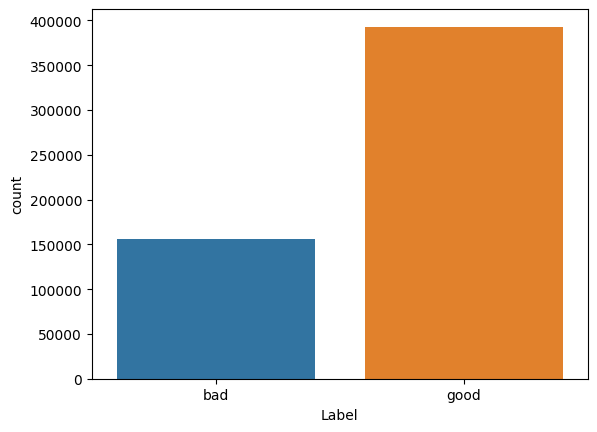

In [8]:
sns.countplot(x='Label', data=df)

#### Ingenieria de Caracteristicas

In [9]:
from six.moves import cPickle as pickle
with open('datasets/URLs/d_common_en_words' + '.pickle', 'rb') as f:
    d = pickle.load(f)

In [10]:
def entropyShanon (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ]
    H = - sum([ p * np.log2(p) for p in prob ])
    return H

def firstDigitIndex(s):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception
        ratio = 0
    return ratio

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
# http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf

def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers
    # if you want to extract multipe ngrams and have them all in one list

    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length

    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized

    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature

def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)


#Extraido de https://redcanary.com/blog/threat-hunting-entropy/
def relative_entropy(data):
    # Remove TLDs and instances of 'www' so 'www.google.com' would be treated as 'google' and 'images.google.com' would be 'images.google'.
    
    # print(data)
    data = data.replace('www.', '')
    # Remove http:// and https://.
    data = data.split('://')[-1]
    # Remove subdomains.
    data = data.split('.')[0]

    if "/" in data:
        data = data.split('/')[0]

    data = data.lower()

    #Calculate the relative entropy (Kullback-Leibler divergence) between data and expected values.
    entropy = 0.0
    length = len(data) * 1.0

    try:

        if length > 0:
            cnt = Counter(data)

            # These probability numbers were calculated from the Alexa Top
            # 1 million domains as of September 15th, 2017. TLDs and instances
            # of 'www' were removed so 'www.google.com' would be treated as
            # 'google' and 'images.google.com' would be 'images.google'.
            probabilities = {
                '-': 0.013342298553905901,
                '_': 9.04562613824129e-06,
                '0': 0.0024875471880163543,
                '1': 0.004884638114650296,
                '2': 0.004373560237839663,
                '3': 0.0021136613076357144,
                '4': 0.001625197496170685,
                '5': 0.0013070929769758662,
                '6': 0.0014880054997406921,
                '7': 0.001471421851820583,
                '8': 0.0012663876593537805,
                '9': 0.0010327089841158806,
                'a': 0.07333590631143488,
                'b': 0.04293204925644953,
                'c': 0.027385633133525503,
                'd': 0.02769469202658208,
                'e': 0.07086192756262588,
                'f': 0.01249653250998034,
                'g': 0.038516276096631406,
                'h': 0.024017645001386995,
                'i': 0.060447396668797414,
                'j': 0.007082725266242929,
                'k': 0.01659570875496002,
                'l': 0.05815885325582237,
                'm': 0.033884915513851865,
                'n': 0.04753175014774523,
                'o': 0.09413783122067709,
                'p': 0.042555148167356144,
                'q': 0.0017231917793349655,
                'r': 0.06460084667060655,
                's': 0.07214640647425614,
                't': 0.06447722311338391,
                'u': 0.034792493336388744,
                'v': 0.011637198026847418,
                'w': 0.013318176884203925,
                'x': 0.003170491961453572,
                'y': 0.016381628936354975,
                'z': 0.004715786426736459,
            }

            for char, count in cnt.items():
                observed = count / length
                expected = probabilities[char]
                entropy += observed * np.log2(observed / expected)

            return entropy
        
    except Exception as e:
        return
    

# Presencia de direccion IP en la URL
def ip_address_presence (x):
    # Check for IP address in URL
    ip_pattern = re.compile('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)')
    if re.search(ip_pattern, x):
        return 1
    else:
        return 0


# Caracteres especiales en la URL
def special_chars_presence (x):
    # Check for special characters in URL
    special_chars_pattern = re.compile('([%$&+,:;=?@#|])')
    if re.search(special_chars_pattern, x):
        return 1
    else:
        return 0

# Presencia de puertos en la URL
def port_presence (x):
    # Check for port in URL
    port_pattern = re.compile('(:[0-9]+)')
    if re.search(port_pattern, x):
        return 1
    else:
        return 0

# Cantidad de subdominios en la URL
def subdomain_count (x):
    # Count subdomains
    subdomains = x.split('.')
    return len(subdomains)

# Cantidad de terminos comunes en la URL (www, com, net, org, etc)

def common_terms_count (x):
    # Count common terms
    common_terms = ['www', 'com', 'net', 'org', 'info', 'biz', 'us', 'uk', 'ca', 'de', 'jp', 'fr', 'au', 'in', 'it', 'cn', 'gov', 'https', 'http', '//']
    count = 0
    for term in common_terms:
        if term in x:
            count += 1
    return count

# Presencia de guiones en la URL
def hyphen_presence (x):
    # Check for hyphens in URL
    hyphen_pattern = re.compile('(-)')
    if re.search(hyphen_pattern, x):
        return 1
    else:
        return 0

# Presencia de doble guion bajo en la URL
def double_hyphen_presence (x):
    # Check for double hyphens in URL
    double_hyphen_pattern = re.compile('(__)')
    if re.search(double_hyphen_pattern, x):
        return 1
    else:
        return 0

# URL Acortada
def shortening_service_presence (x):
    # Check for shortening service in URL
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl.com', 'ow.ly', 't.co', 'tiny.cc', 'bit.do', 'mcaf.ee', 'cli.gs', 'yfrog.com', 'twit.ac', 'su.pr', 'lnkd.in', 'db.tt', 'qr.ae', 'adf.ly', 'goo.gl', 'bitly.com', 'cur.lv', 'tiny.cl', 'po.st', 'bc.vc', 'twitthis.com', 'u.to', 'j.mp', 'buzurl.com', 'cutt.us', 'u.bb', 'yourls.org', 'x.co', 'prettylinkpro.com', 'scrnch.me', 'filoops.info', 'vzturl.com', 'qr.net', '1url.com', 'tweez.me', 'v.gd', 'tr.im', 'link.zip.net']
    for service in shortening_services:
        if service in x:
            return 1
    return 0

# Subdominios abnormales
def abnormal_subdomain_presence (x):
    # Check for abnormal subdomains
    abnormal_subdomains = ['sc', 'dc', 'oc', 'ac', 'info', 'mail', 'home', 'corp', 'download', 'product', 'support', 'payment', 'login', 'secure', 'account', 'admin', 'administrator', 'root', 'blog', 'blogspot', 'wordpress', 'web', 'webs', 'website', 'net', 'org', 'in', 'co', 'cc', 'biz', 'info', 'name', 'pro', 'tel', 'mobi', 'aero', 'asia', 'cat', 'coop', 'jobs', 'museum', 'travel', 'arpa', 'root', 'local', 'onion', 'example', 'invalid', 'test', 'localhost', 'localdomain', 'local']
    for subdomain in x.split('.'):
        if subdomain in abnormal_subdomains:
            return 1
    return 0

#### Preprocesamiento

In [11]:
df['URL'] = df['URL'].str.strip("'")

In [12]:
df['ngrams'] = df['URL'].apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1),
                                                                ngram_feature(x, d, 2),
                                                                ngram_feature(x, d, 3)]))

df['entropy'] = df['URL'].apply(entropyShanon)
df['entropyRelative'] = df['URL'].apply(relative_entropy)
df['vowel-cons'] = df['URL'].apply(vowel_consonant_ratio)
df['firstDigitIndex'] = df['URL'].apply(firstDigitIndex)
df['length'] = df['URL'].str.len()
df['digits'] = df['URL'].str.count('[0-9]')

#Ip address presence
df['ip'] = df['URL'].apply(ip_address_presence)
#Special characters presence
df['special'] = df['URL'].apply(special_chars_presence)
#Port presence
df['port'] = df['URL'].apply(port_presence)
#Subdomain count
df['subdomain'] = df['URL'].apply(subdomain_count)
#Common terms count
df['common'] = df['URL'].apply(common_terms_count)
#Hyphen presence
df['hyphen'] = df['URL'].apply(hyphen_presence)
#Double hyphen presence
df['doubleHyphen'] = df['URL'].apply(double_hyphen_presence)
#Shortening service presence
df['shortening'] = df['URL'].apply(shortening_service_presence)
#Abnormal subdomain presence
df['abnormal'] = df['URL'].apply(abnormal_subdomain_presence)

df['Label'] = df['Label'].map({'good': 0, 'bad': 1})
print(df["Label"].value_counts())
df.sample(n=10).head()


0    392924
1    156422
Name: Label, dtype: int64


,URL,Label,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits,ip,special,port,subdomain,common,hyphen,doubleHyphen,shortening,abnormal
327760,facebook.com/keith.carr,0,1144.996361,3.675311,1.796745,0.666667,0,23,0,0,0,0,3,3,0,0,0,0
204516,kansascity.sbnation.com/kansas-city-royals/201...,0,1106.389276,4.497868,1.533872,0.583333,44,129,14,0,0,0,3,4,1,0,0,0
181070,en.wikipedia.org/wiki/Talk:Mordecai_Richler,0,1147.787236,4.125889,3.106905,0.761905,0,43,0,0,1,0,3,3,0,0,0,0
326419,facebook.com/airagarces,0,1322.407554,3.588354,1.796745,0.909091,0,23,0,0,0,0,2,1,0,0,0,0
340461,fok.cz/en/guest-artists.html,0,1144.129562,4.137538,3.629856,0.352941,0,28,0,0,0,0,3,0,1,0,0,0


<AxesSubplot: xlabel='Label', ylabel='count'>

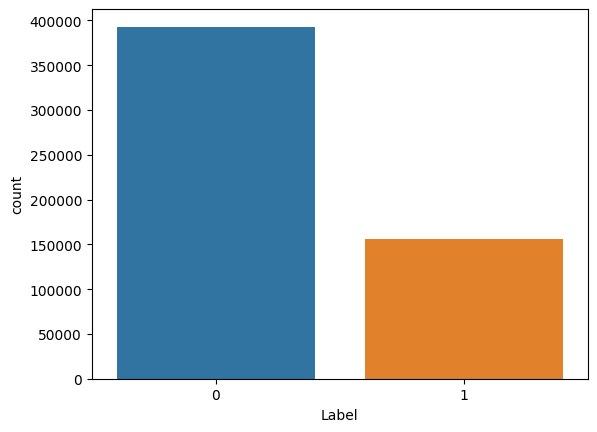

In [13]:
sns.countplot(x='Label', data=df)

#### Balanceo de data

In [14]:
# Balanceo de data
# Under-sampling
safe_urls = df[df['Label'] == 0]
phishing_urls = df[df['Label'] == 1]
safe_urls = safe_urls.sample(phishing_urls.shape[0])

data = pd.concat([safe_urls, phishing_urls], axis=0, ignore_index=True)


,URL,Label,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits,ip,special,port,subdomain,common,hyphen,doubleHyphen,shortening,abnormal
0,limasenior65.com/class_classmates.cfm,0,1285.181153,3.796895,1.514430,0.476190,11,37,2,0,0,0,3,1,0,0,0,0
1,komintl.com/,0,1066.707576,3.251629,1.579417,0.428571,0,12,0,0,0,0,2,2,0,0,0,0
2,amazon.com/Moyers-Democracy-Bill/dp/0307387739,0,784.985932,4.468577,2.407407,0.500000,37,46,10,0,0,0,2,1,1,0,0,0
3,earcom.com/planet3/,0,1222.527921,3.616349,1.585574,0.666667,18,19,1,0,0,0,2,2,0,0,0,0
4,genforum.genealogy.com/alvis/all.html,0,1143.877742,4.016508,1.540526,0.523810,0,37,0,0,0,0,4,1,0,0,0,0


In [19]:
# Remove URL column
data = data.drop(['URL'], axis=1)
data.head()

,Label,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits,ip,special,port,subdomain,common,hyphen,doubleHyphen,shortening,abnormal
0,0,1285.181153,3.796895,1.514430,0.476190,11,37,2,0,0,0,3,1,0,0,0,0
1,0,1066.707576,3.251629,1.579417,0.428571,0,12,0,0,0,0,2,2,0,0,0,0
2,0,784.985932,4.468577,2.407407,0.500000,37,46,10,0,0,0,2,1,1,0,0,0
3,0,1222.527921,3.616349,1.585574,0.666667,18,19,1,0,0,0,2,2,0,0,0,0
4,0,1143.877742,4.016508,1.540526,0.523810,0,37,0,0,0,0,4,1,0,0,0,0


In [22]:
# Randomize positions of rows
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Label,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits,ip,special,port,subdomain,common,hyphen,doubleHyphen,shortening,abnormal
0,0,1115.598566,3.977917,2.005666,0.529412,0,31,0,0,0,0,3,1,0,0,0,0
1,0,1001.474098,4.603910,0.927006,0.413793,28,52,5,0,1,0,2,1,0,0,0,0
2,1,906.089373,4.523662,1.522060,0.437500,36,60,5,0,0,0,3,2,1,0,0,0
3,0,1245.802729,3.684184,1.905297,0.545455,0,20,0,0,0,0,2,1,0,0,0,0
4,0,1190.114781,3.936180,2.709537,0.583333,0,23,0,0,0,0,2,2,1,0,0,0


(312844, 17)


<AxesSubplot: xlabel='Label', ylabel='count'>

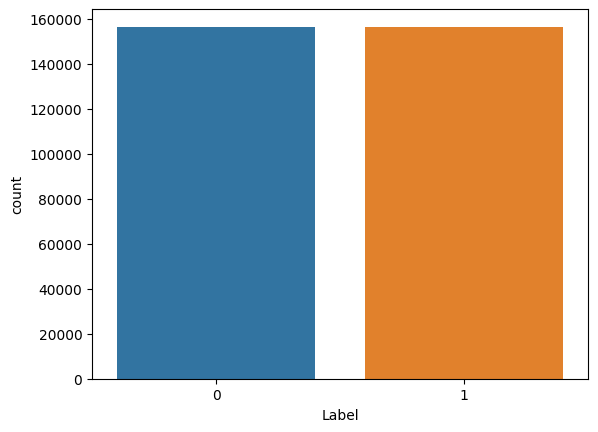

In [23]:
print(data.shape)
sns.countplot(x='Label', data=data)

In [24]:
# Guardar el dataset limpio
data.to_csv('datasets/URLs/phishing_site_urls_clean.csv', index=False)

In [ ]:
data = pd.read_csv('datasets/URLs/phishing_site_urls_clean.csv')